# Setup

## Import Library

In [1]:
import os
import asyncio
import nest_asyncio
import importlib
import time
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess
from tensorflow.keras import layers, models
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.optimizers import Adam
from PIL import Image
from dotenv import load_dotenv
from telegram import Bot, InputFile
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from tensorflow.keras.applications import (
    MobileNetV3Small,
    MobileNetV3Large,
    EfficientNetV2B0,
    EfficientNetV2B1,
    EfficientNetV2B2,
    EfficientNetV2B3,
    EfficientNetV2S,
    EfficientNetV2M,
    EfficientNetV2L
)

from efficientNet.efficientnet_v2_modifikasi import (
    EfficientNetV2B0Modifikasi,
    EfficientNetV2B1Modifikasi,
    EfficientNetV2B2Modifikasi,
    EfficientNetV2B3Modifikasi,
)

importlib.reload(importlib.import_module('efficientNet.efficientnet_v2_modifikasi'))

2024-12-23 21:34:54.327303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734964494.529400   12565 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734964494.580768   12565 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 21:34:55.015341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'efficientNet.efficientnet_v2_modifikasi' from '/home/abiyamf/TelU-Tubes-ProjectAkhir-BeanLeaf/efficientNet/efficientnet_v2_modifikasi.py'>

## Bot Telegram

In [2]:
# setup loop
nest_asyncio.apply()

In [21]:
def send_telegram_message(message, image_path=None):
    async def _send_message():
        # Muat variabel lingkungan dari file .env
        load_dotenv()
        bot = Bot(token=os.getenv("TELEGRAM_TOKEN"))

        # Ambil chat ID dari file .env
        chat_id_abiya = os.getenv("TELEGRAM_CHAT_ID_ABIYA")
        chat_id_falah = os.getenv("TELEGRAM_CHAT_ID_FALAH")
        chat_id_akif = os.getenv("TELEGRAM_CHAT_ID_AKIF")

        if image_path:
            with open(image_path, 'rb') as file_abiya:
                await bot.send_photo(chat_id=chat_id_abiya, photo=file_abiya, caption=message, read_timeout=60, write_timeout=60)

            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_falah:
                await bot.send_photo(chat_id=chat_id_falah, photo=file_falah, caption=message,read_timeout=60, write_timeout=60)
                
            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_akif:
                await bot.send_photo(chat_id=chat_id_akif, photo=file_akif, caption=message,read_timeout=60, write_timeout=60)                
        else:
            await bot.send_message(chat_id=chat_id_abiya, text=message)
            await bot.send_message(chat_id=chat_id_falah, text=message)
            await bot.send_message(chat_id=chat_id_akif, text=message)

    # Jalankan coroutine menggunakan event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(_send_message())

def send_training_start_message(model_name,img_size,batch_size,epochs_size):
    send_telegram_message((
        "🚀 Starting training!\n\n"
        f"Model: {model_name}\n"
        f"Image Size: {img_size[0]}x{img_size[1]}\n"
        f"Batch Size: {batch_size}\n"
        f"Epochs Size: {epochs_size}\n"
        "⏳ Preparing for training....\n"
        "Stay tuned for updates! 📈")
    )

def send_training_end_message(model_name,total_duration, training_accuracy, validation_accuracy, testing_accuracy,total_parameters):
    send_telegram_message(
        f"🎉 Training Completed!\n\n"
        f"Model: {model_name}\n"
        f"🕒 Total Duration: {total_duration}\n"
        f"Training Accuracy: {training_accuracy}\n"
        f"Validation Accuracy: {validation_accuracy}\n"
        f"Testing Accuracy: {testing_accuracy}\n"
        f"Total Parameter: {total_parameters}\n"
        "📊 Check out the final results and plots for performance analysis.\n\n"
        "Thank you for your patience! 🙏"
    )

def notify_on_error(shell, etype, evalue, tb, tb_offset=None):
    # Ambil tipe error dan pesan utamanya
    error_type = etype.__name__
    error_message = str(evalue)
    summary_message = f"⚠️ Error Detected in Notebook Cell ⚠️\n\nType: {error_type}\nMessage: {error_message}"
    
    # Kirim pesan ke Telegram
    send_telegram_message(summary_message)

    # Tampilkan error di Jupyter Notebook tanpa `raise`
    traceback.print_exception(etype, evalue, tb)

# Registrasi hook error
InteractiveShell.instance().set_custom_exc((Exception,), notify_on_error)

In [4]:
# Test message
send_telegram_message("test message")

## Download dan Extract Datasets

In [5]:
# Cek apakah file dataset.zip sudah ada
dataset_zip_path = "dataset.zip"

if not os.path.exists(dataset_zip_path):
    #Mendownload dataset
    !gdown 1xP8hy5ZhkD_B18HCoQyFKIDs2tn-qZ6b -O dataset.zip
    
    #Melakukan unzip file dataset
    !unzip -qo dataset.zip
else:
    print("File dataset.zip sudah ada. Melewati proses download.")

File dataset.zip sudah ada. Melewati proses download.


# Cek GPU

In [6]:
# Cek apakah GPU tersedia
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# EDA

## Jumlah data

In [7]:
def count_images_in_folder(folder_path):
    """Menghitung jumlah gambar dalam folder dan subfolder."""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])  # Sesuaikan ekstensi file
    return count

# Path ke folder datasets
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung jumlah gambar di folder training
training_count = count_images_in_folder(training_path)
print(f"Jumlah gambar di folder training: {training_count}")

# Total jumlah gambar di folder testing
total_testing_count = count_images_in_folder(testing_path)
print(f"Jumlah gambar di folder testing: {total_testing_count}")

Jumlah gambar di folder training: 932
Jumlah gambar di folder testing: 134


## Distribusi datasets

Distribusi dataset untuk training: {'bean_rust': 314, 'angular_leaf_spot': 311, 'healthy': 307}


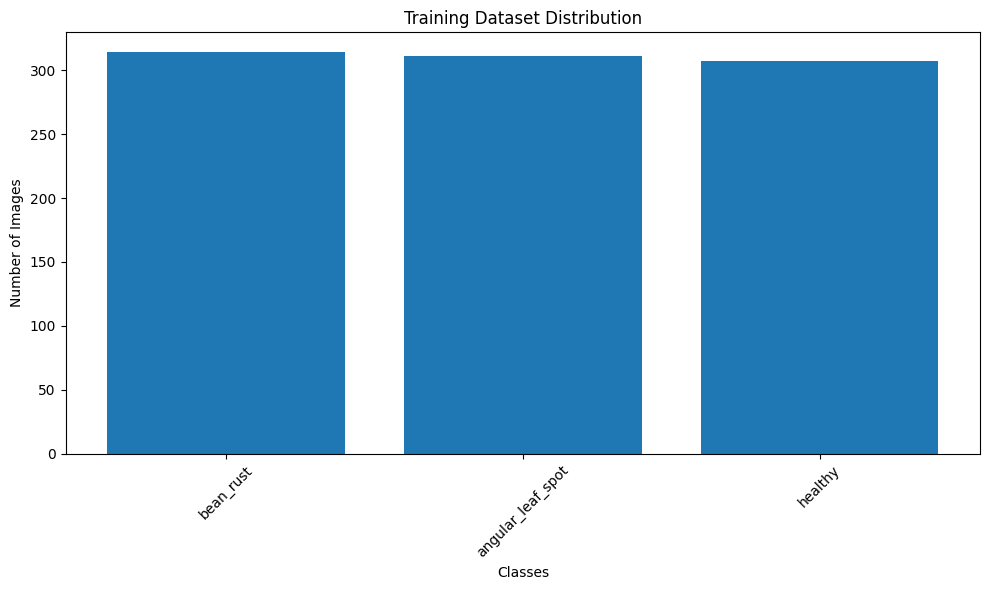

Distribusi dataset untuk testing: {'bean_rust': 45, 'angular_leaf_spot': 44, 'healthy': 44}


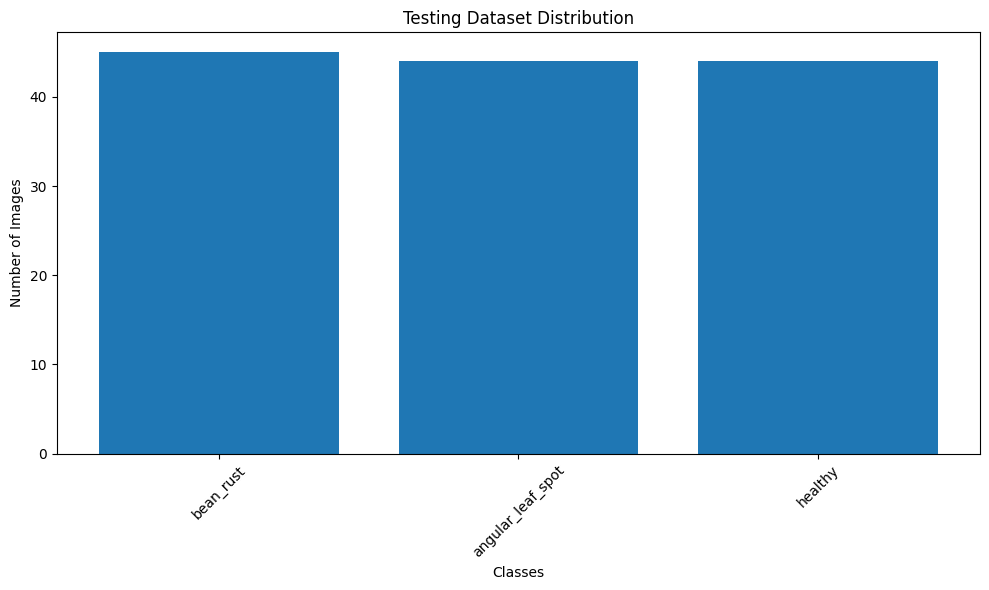

In [8]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder (kelas)
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung distribusi kelas untuk training
training_class_counts = count_images_in_classes(training_path)
print(f"Distribusi dataset untuk training: {training_class_counts}")
plot_distribution(training_class_counts, "Training Dataset Distribution")

# Hitung distribusi kelas untuk testing
testing_class_counts = count_images_in_classes(testing_path)
print(f"Distribusi dataset untuk testing: {testing_class_counts}")
plot_distribution(testing_class_counts, "Testing Dataset Distribution")

## Preview datasets

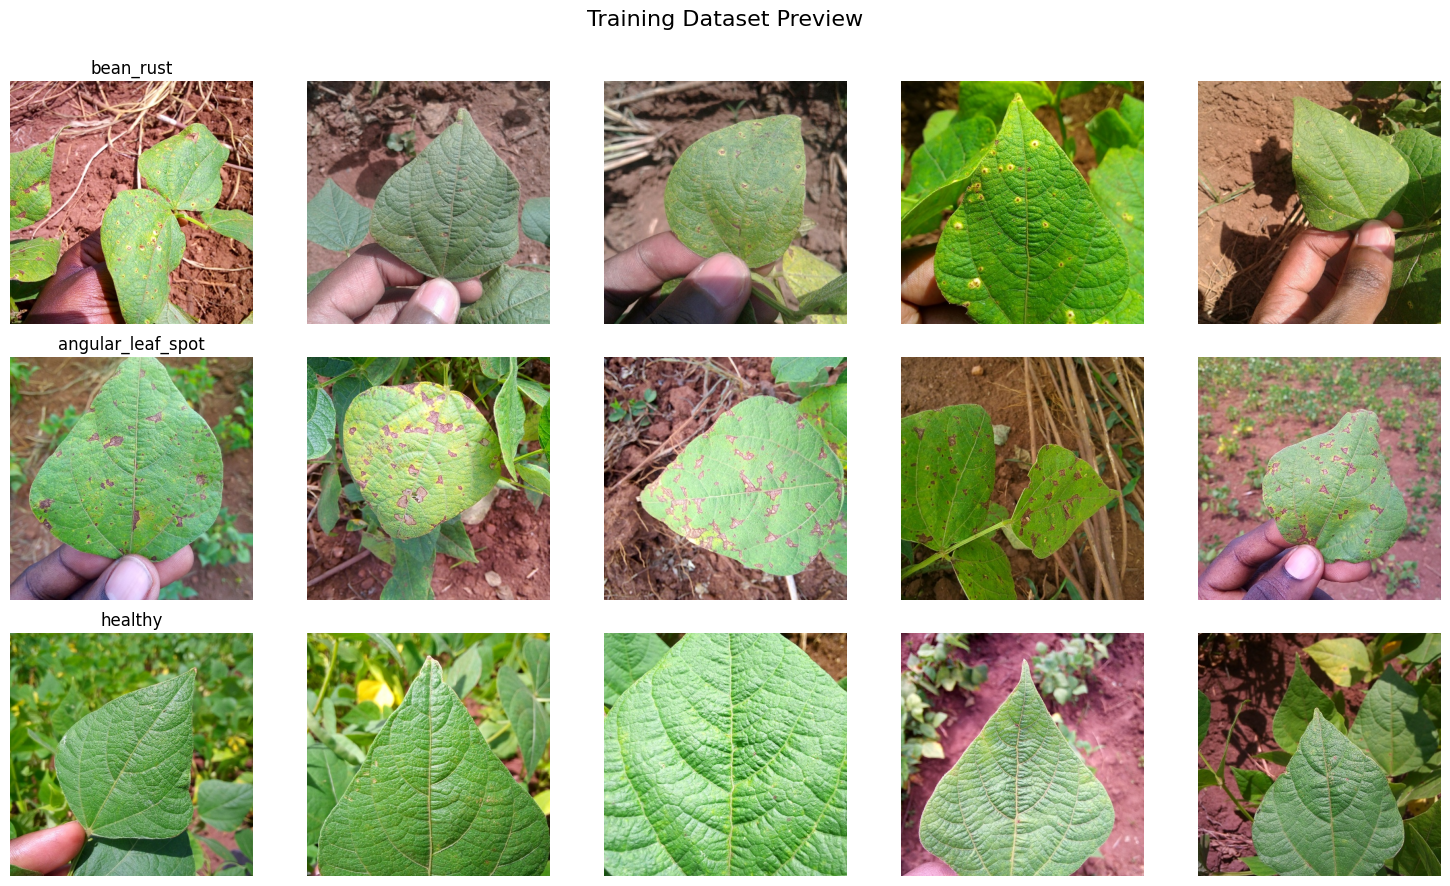

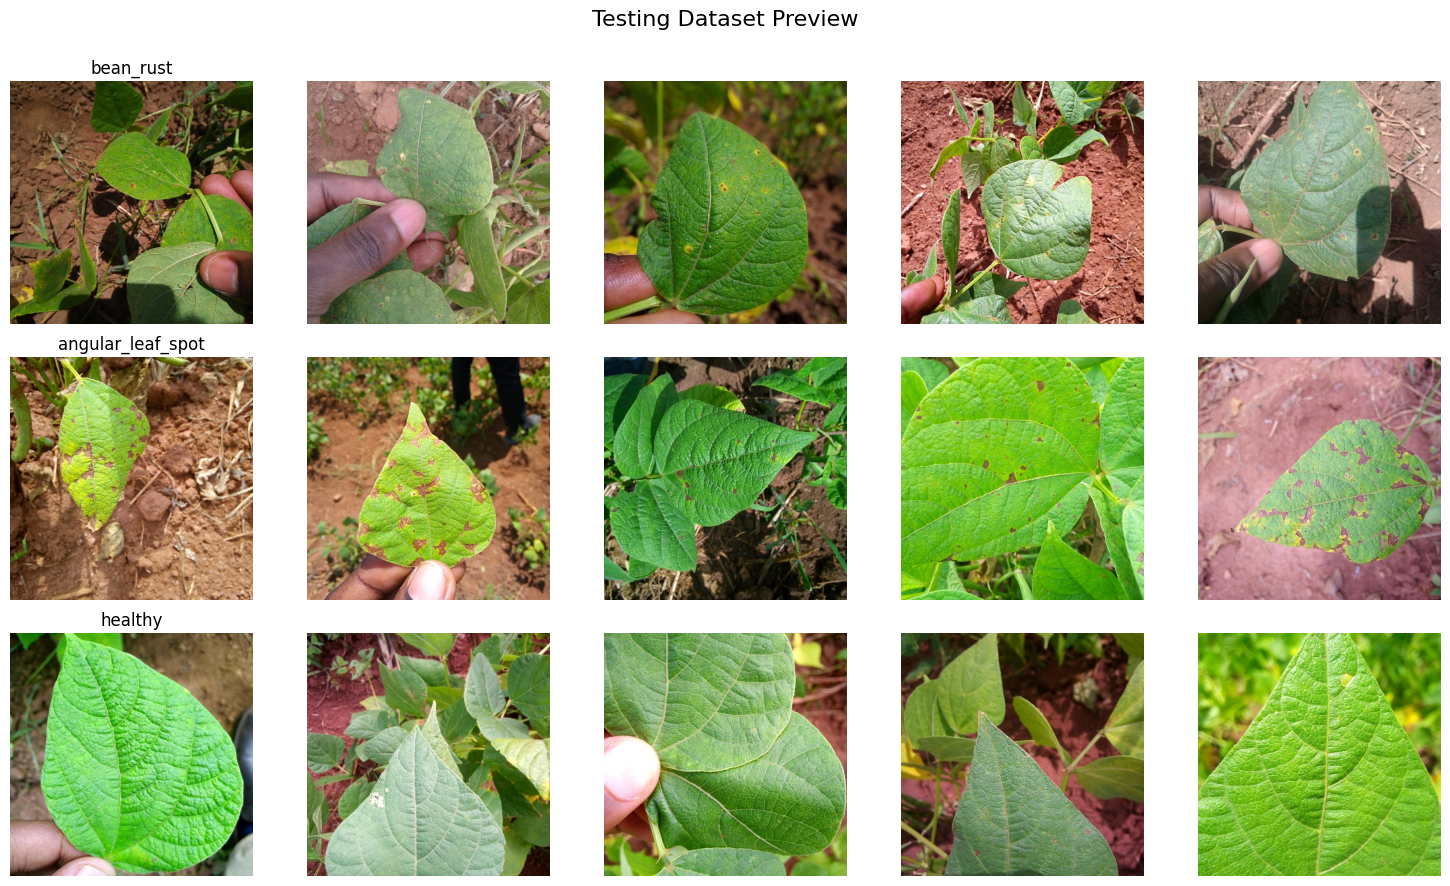

In [9]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        sample_images = images[:samples_per_class]  # Ambil sejumlah gambar untuk preview

        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Preview gambar di folder training
preview_images(training_path, "Training Dataset Preview", samples_per_class=5)

# Preview gambar di folder testing
preview_images(testing_path, "Testing Dataset Preview", samples_per_class=5)

# MobileNetV3

In [10]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "MobileNetV3Small": MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    "MobileNetV3Large": MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

I0000 00:00:1734964509.649693   12565 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model Parameter Count
0  MobileNetV3Small         939.120
1  MobileNetV3Large       2.996.352

# EfficientNetV2

In [11]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2B0": EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False),
    "EfficientNetV2B1": EfficientNetV2B1(input_shape=(240, 240, 3), include_top=False),
    "EfficientNetV2B2": EfficientNetV2B2(input_shape=(260, 260, 3), include_top=False),
    "EfficientNetV2B3": EfficientNetV2B3(input_shape=(300, 300, 3), include_top=False)
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Model Parameter Count
0  EfficientNetV2B0       5.919.312
1  EfficientNetV2B1       6.931.124
2  EfficientNetV2B2       8.769.374
3  EfficientNetV2B3      12.930.622

# EfficientNetV2 Modifikasi

In [12]:
import pandas as pd

# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi(input_shape=(224, 224, 3), include_top=False, weights=None),
    "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi(input_shape=(240, 240, 3), include_top=False, weights=None),
    "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi(input_shape=(260, 260, 3), include_top=False, weights=None),
    "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi(input_shape=(300, 300, 3), include_top=False, weights=None)
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Model Parameter Count
0  EfficientNetV2B0Modifikasi       1.540.516
1  EfficientNetV2B1Modifikasi       1.977.816
2  EfficientNetV2B2Modifikasi       2.301.516
3  EfficientNetV2B3Modifikasi       3.244.318

# Training

## Variabel Global

In [13]:
dataset_path = "datasets/"
save_model_path = "results/best_model/"
result_csv_path = "results/csv/"
image_path = "results/images/"

In [14]:
# Dataset directories
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testing")

input_shapes = {
    "MobileNetV3Small": (224, 224),
    "MobileNetV3Large": (224, 224),
    "EfficientNetV2B0": (224, 224),
    "EfficientNetV2B1": (240, 240),
    "EfficientNetV2B2": (260, 260),
    "EfficientNetV2B3": (300, 300),
    "EfficientNetV2B0Modifikasi": (224, 224),
    "EfficientNetV2B1Modifikasi": (240, 240),
    "EfficientNetV2B2Modifikasi": (260, 260),
    "EfficientNetV2B3Modifikasi": (300, 300),
}

# Random seed
random.seed(42)

## Hyperparameter settings

In [15]:
batch_size = 32
epochs_size = 25
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage = 0.3
trainable_percentage_modifikasi = 1

## Split dataset

In [16]:
def count_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return sum(len(files) for _, _, files in os.walk(folder_path) if files)

# Fungsi untuk melakukan split
def split_training_data(train_dir, val_dir, validation_split=0.1):
    if os.path.exists(val_dir):
        print(f"Folder '{val_dir}' sudah ada. Tidak melakukan split ulang.")
        return

    os.makedirs(val_dir, exist_ok=True)
    
    # Iterasi setiap kelas di folder training
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue
        
        os.makedirs(class_val_path, exist_ok=True)

        # Ambil semua file gambar di kelas ini
        all_images = [f for f in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, f))]
        total_images = len(all_images)

        # Pilih 10% gambar secara acak untuk dipindahkan ke validation
        val_size = int(total_images * validation_split)
        val_images = random.sample(all_images, val_size)

        # Pindahkan gambar ke folder validation
        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dest_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dest_path)

# Hitung jumlah gambar sebelum split
print("Sebelum split:")
train_count_before = count_images_in_folder(train_dir)
val_count_before = count_images_in_folder(val_dir)
print(f"  Training: {train_count_before} gambar")
print(f"  Validation: {val_count_before} gambar")

# Lakukan split
split_training_data(train_dir, val_dir, validation_split=0.1)

# Hitung jumlah gambar setelah split
print("\nSetelah split:")
train_count_after = count_images_in_folder(train_dir)
val_count_after = count_images_in_folder(val_dir)
print(f"  Training: {train_count_after} gambar")
print(f"  Validation: {val_count_after} gambar")

Sebelum split:
  Training: 932 gambar
  Validation: 102 gambar
Folder 'datasets/validation' sudah ada. Tidak melakukan split ulang.

Setelah split:
  Training: 932 gambar
  Validation: 102 gambar


## Data augmentation

In [17]:
# Data augmentation and preprocessing mobileNetV3
def augmentation_generator_MBV3(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=mobilenetv3_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenetv3_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

In [18]:
# Data augmentation and preprocessing efficientNetV2
def augmentation_generator_ENV2(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=efficientnetv2_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

## Build model

In [19]:
def load_base_model(model_name, img_height, img_width, trainable_percentage):
    # Dictionary mapping untuk model-model yang didukung
    model_mapping = {
        "MobileNetV3Small": MobileNetV3Small,
        "MobileNetV3Large": MobileNetV3Large,
        "EfficientNetV2B0": EfficientNetV2B0,
        "EfficientNetV2B1": EfficientNetV2B1,
        "EfficientNetV2B2": EfficientNetV2B2,
        "EfficientNetV2B3": EfficientNetV2B3,
        "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi,
        "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi,
        "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi,
        "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi,
    }
    
    # Validasi model_name
    if model_name not in model_mapping:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Inisialisasi model berdasarkan mapping
    if "Modifikasi" not in model_name:
        base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                               include_top=False, 
                                               weights='imagenet')
    else:
            base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                           include_top=False, 
                                           weights=None)
    
    # Mengatur layer trainable berdasarkan persentase
    trainable_layers = int(trainable_percentage * len(base_model.layers))
    for layer in base_model.layers[:trainable_layers]:
        layer.trainable = True
    for layer in base_model.layers[trainable_layers:]:
        layer.trainable = False

    # Build model
    model = build_model(base_model, train_generator.num_classes, dropout_rate)
    
    # Compile model
    compile_model(model, learning_rate)
    
    return model


def build_model(base_model, num_classes,dropout_rate):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

def train_model(model, train_generator, val_generator, epochs_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs_size,
        validation_data=val_generator
    )
    duration = time.time() - start_time
    return history, duration

def evaluate_model(model, test_generator):
    eval_result = model.evaluate(test_generator)
    return eval_result[1] * 100, eval_result[0]

def save_model(model, save_path, timestamp, model_name):
    model_save_path = os.path.join(save_path, f"{model_name}_{timestamp}.h5")
    model.save(model_save_path)
    return model_save_path

def save_results_to_csv(results, csv_save_path):
    df = pd.DataFrame(results)
    if os.path.exists(csv_save_path):
        existing_df = pd.read_csv(csv_save_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_save_path, index=False)

def plot_training_metrics(history, image_path, timestamp):
    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(os.path.join(image_path, f"training_accuracy_{timestamp}.png"))
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(image_path, f"training_loss_{timestamp}.png"))
    plt.show()

def plot_confusion_matrix(model, test_generator, image_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_generator.class_indices)))

    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    confusion_matrix_path = os.path.join(image_path, f"confusion_matrix_{timestamp}.png")
    fig.savefig(confusion_matrix_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)
    return confusion_matrix_path

def run_training(model):
    # Send training start message
    send_training_start_message(model_name, (img_height, img_width), batch_size, epochs_size)
    
    # Train model
    history, training_duration = train_model(model, train_generator, val_generator, epochs_size)
    
    # Evaluate model
    test_accuracy, test_loss = evaluate_model(model, test_generator)
    
    # Save model
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    save_model(model, save_model_path, timestamp,model_name)
    
    # Save results
    results = {
        "Timestamp": [timestamp],
        "Model": [model_name],
        "Batch Size": [batch_size],
        "Epochs": [epochs_size],
        "Training Accuracy": [max(history.history['accuracy']) * 100],
        "Validation Accuracy": [max(history.history['val_accuracy']) * 100],
        "Testing Accuracy": [test_accuracy],
        "Training Loss": [min(history.history['loss'])],
        "Validation Loss": [min(history.history['val_loss'])],
        "Testing Loss": [test_loss],
        "Training Duration (seconds)": [training_duration],
        "Training Duration (minutes)": [f"{training_duration / 60:.2f}"],
        "Trainable Percentage": [trainable_percentage_modifikasi * 100 if "Modifikasi" in model_name else trainable_percentage * 100],
        "Total Parameter": [f"{model.count_params():,}".replace(",", ".")]
    }
    save_results_to_csv(results, os.path.join(result_csv_path, "training_results.csv"))

    show_classification_report(model, test_generator, result_csv_path, timestamp)

    return history, image_path, timestamp, model, training_duration, test_accuracy

def plot_history(history, image_path, timestamp, model, training_duration, test_accuracy):
    # Plot metrics
    plot_training_metrics(history, image_path, timestamp)
    
    # Plot confusion matrix
    confusion_matrix_path = plot_confusion_matrix(model, test_generator, image_path, timestamp)
    
    # Send training end message
    send_training_end_message(
        model_name,
        total_duration=f"{training_duration / 60:.2f} minutes",
        training_accuracy=(history.history['accuracy'][-1])* 100,
        validation_accuracy=(history.history['val_accuracy'][-1])* 100,
        testing_accuracy=test_accuracy,
        total_parameters=f"{model.count_params():,}".replace(",", ".")
    )
    
    send_telegram_message("Confusion Matrix", confusion_matrix_path)

def show_classification_report(model, test_generator, save_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Train Model

### MobileNetV3Small

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1734960246.784355    4065 service.cc:148] XLA service 0x7f175c002dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734960246.784527    4065 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-23 20:24:07.066673: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734960248.589250    4065 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734960261.198820    4065 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/30 ━━━━━━━━━━━━━━━━━━━━ 11:18 23s/step - accuracy: 0.1875 - loss: 1.4773

2024-12-23 20:24:27.530563: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[4,16,113,113]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,16,115,115]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=16, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-23 20:24:27.533461: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.277046005s
Trying algorithm eng30{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[4,16,113,113]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,16,115,115]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=16, custom_call_target="__cudnn$convForwa

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4033 - loss: 1.2402 - val_accuracy: 0.6569 - val_loss: 0.6963
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.7529 - loss: 0.5985 - val_accuracy: 0.8333 - val_loss: 0.4481
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.8145 - loss: 0.4474 - val_accuracy: 0.7941 - val_loss: 0.4584
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8421 - loss: 0.3875 - val_accuracy: 0.7353 - val_loss: 0.5702
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.8639 - loss: 0.3596 - val_accuracy: 0.6961 - val_loss: 0.5618
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8233 - loss: 0.4237 


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.62      0.98      0.76        44
        bean_rust       0.92      0.53      0.68        45
          healthy       0.97      0.84      0.90        45

         accuracy                           0.78       134
        macro avg       0.84      0.79      0.78       134
     weighted avg       0.84      0.78      0.78       134



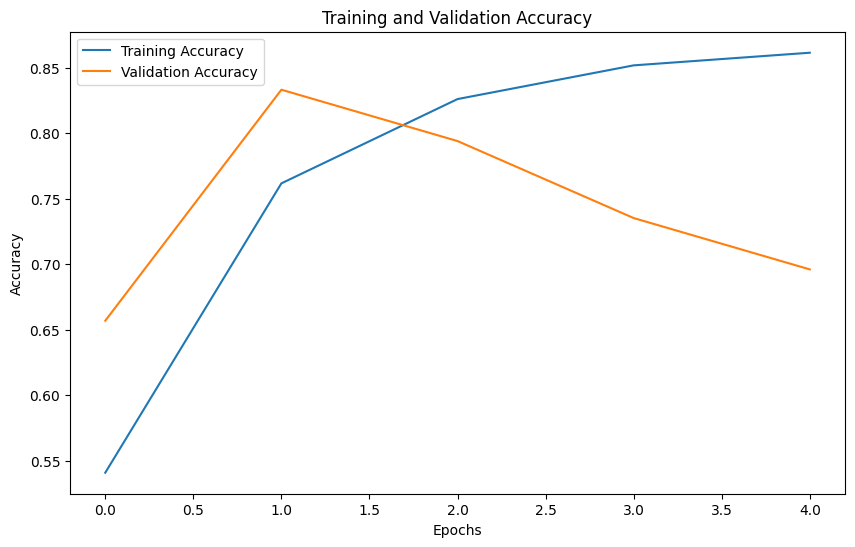

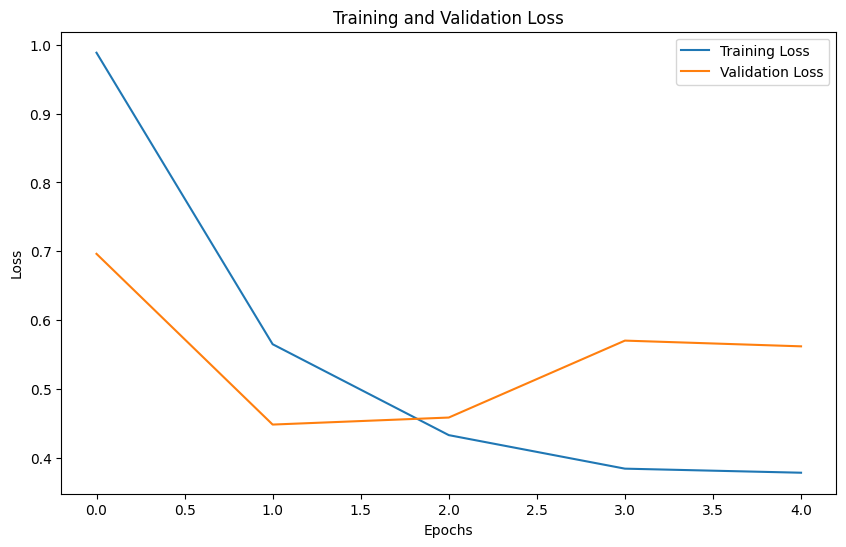

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


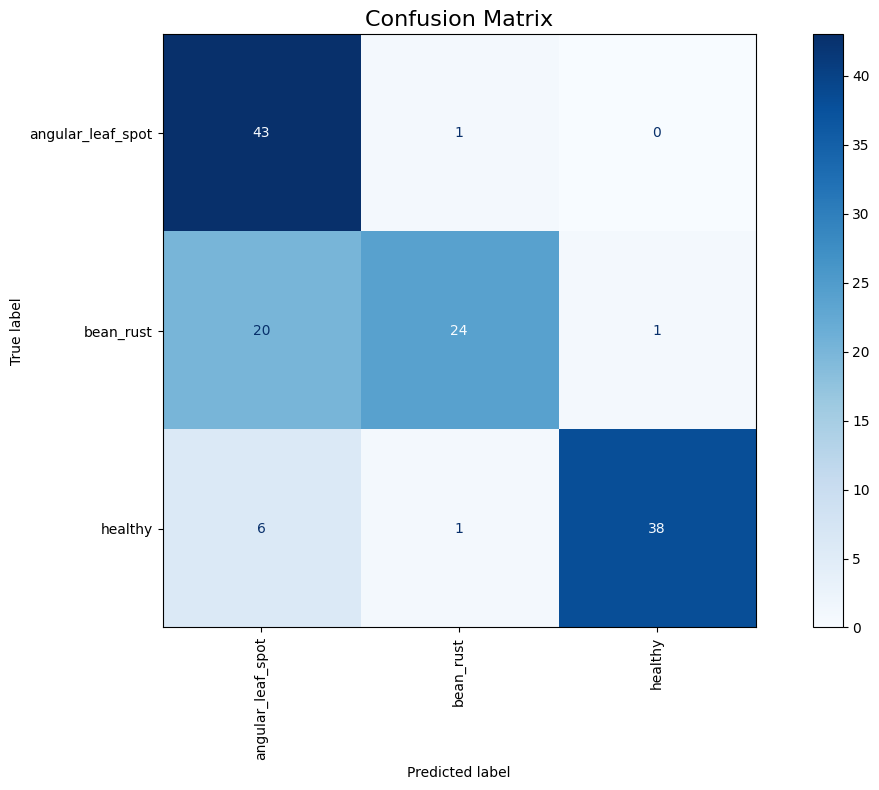

Custom TB Handler failed, unregistering


---------------------------------------------------------------------------
ReadTimeout                               Traceback (most recent call last)
File ~/miniconda3/envs/projectAI/lib/python3.12/site-packages/httpx/_transports/default.py:101, in map_httpcore_exceptions()
    100 try:
--> 101     yield
    102 except Exception as exc:

File ~/miniconda3/envs/projectAI/lib/python3.12/site-packages/httpx/_transports/default.py:394, in AsyncHTTPTransport.handle_async_request(self, request)
    393 with map_httpcore_exceptions():
--> 394     resp = await self._pool.handle_async_request(req)
    396 assert isinstance(resp.stream, typing.AsyncIterable)

File ~/miniconda3/envs/projectAI/lib/python3.12/site-packages/httpcore/_async/connection_pool.py:256, in AsyncConnectionPool.handle_async_request(self, request)
    255     await self._close_connections(closing)
--> 256     raise exc from None
    258 # Return the response. Note that in this case we still have to manage
    259 # the poin

In [19]:
model_name = "MobileNetV3Small"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_MBV3(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### MobileNetV3Large

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5278 - loss: 0.9845 - val_accuracy: 0.8137 - val_loss: 0.4701
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.8312 - loss: 0.4162 - val_accuracy: 0.9118 - val_loss: 0.2441
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.8843 - loss: 0.3081 - val_accuracy: 0.9804 - val_loss: 0.1787
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.9180 - loss: 0.2505 - val_accuracy: 0.9608 - val_loss: 0.1528
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.9170 - loss: 0.2112 - val_accuracy: 0.9706 - val_loss: 0.1178
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.9225 - loss: 0.2024 - val_accuracy: 0.9608 - val_loss: 0.1493
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.9391 - loss: 0.1489 - val_accuracy: 0.9706 - val_loss: 0.1544
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.9388 - loss: 0.1578 - val_accuracy: 0.88

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 944ms/step
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.66      1.00      0.79        44
        bean_rust       1.00      0.49      0.66        45
          healthy       1.00      1.00      1.00        45

         accuracy                           0.83       134
        macro avg       0.89      0.83      0.82       134
     weighted avg       0.89      0.83      0.82       134



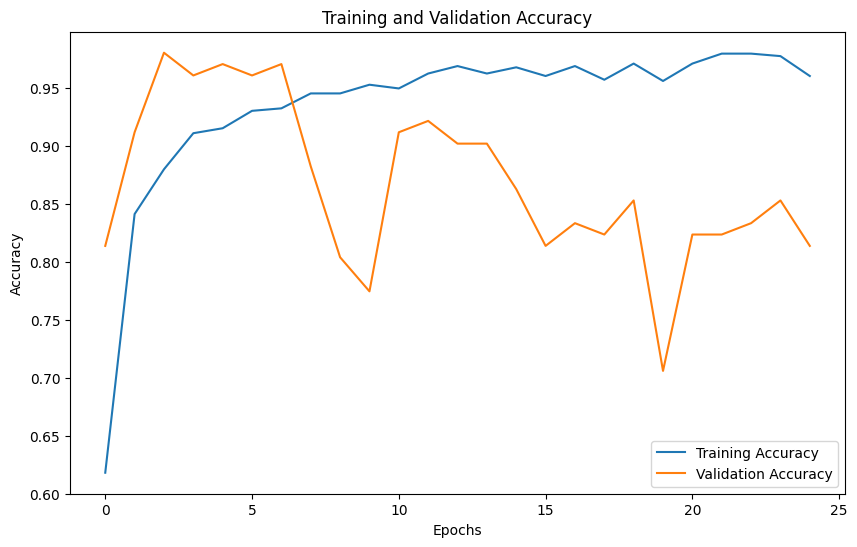

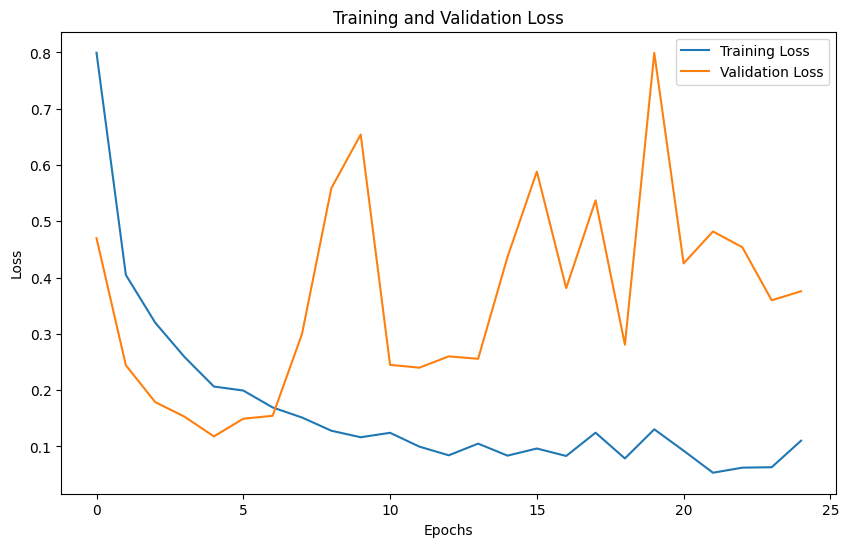

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step 


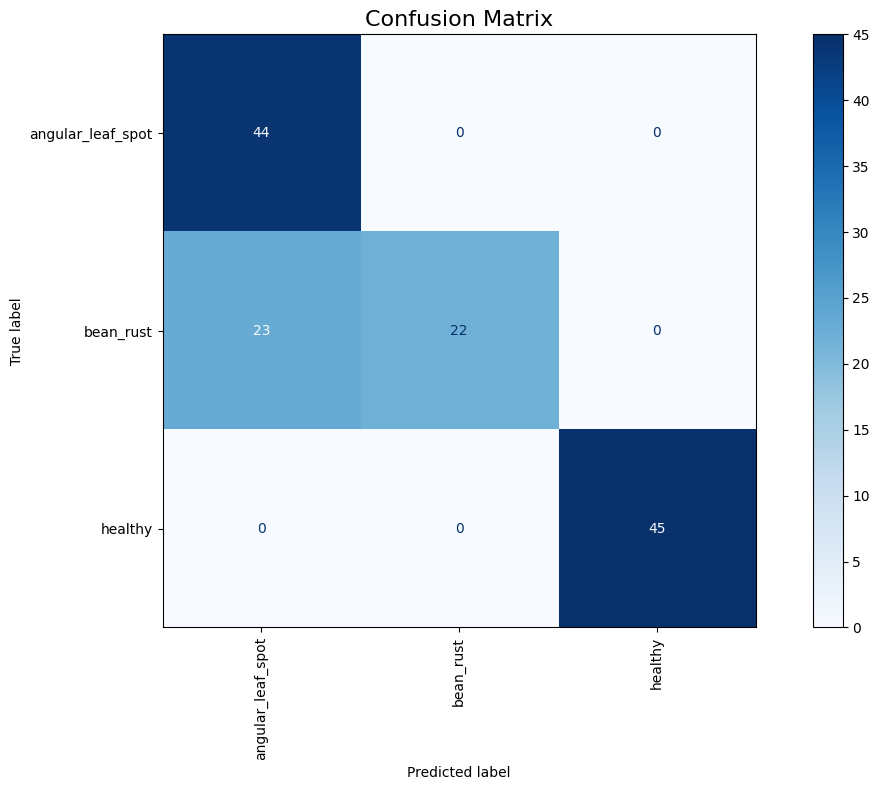

In [26]:
model_name = "MobileNetV3Large"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_MBV3(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B0

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5783 - loss: 0.8581 - val_accuracy: 0.8725 - val_loss: 0.4115
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - accuracy: 0.8918 - loss: 0.2803 - val_accuracy: 0.8333 - val_loss: 0.4702
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.9122 - loss: 0.2051 - val_accuracy: 0.9216 - val_loss: 0.2478
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.9356 - loss: 0.1958 - val_accuracy: 0.9706 - val_loss: 0.1467
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.9487 - loss: 0.1249 - val_accuracy: 0.9314 - val_loss: 0.1859
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.9277 - loss: 0.1815 - val_accuracy: 0.9118 - val_loss: 0.2979
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.9446 - loss: 0.2012 - val_accuracy: 0.9902 - val_loss: 0.0811
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.9753 - loss: 0.0898 - val_accuracy: 0.99

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.98      0.91      0.94        44
        bean_rust       0.94      0.98      0.96        45
          healthy       0.98      1.00      0.99        45

         accuracy                           0.96       134
        macro avg       0.96      0.96      0.96       134
     weighted avg       0.96      0.96      0.96       134



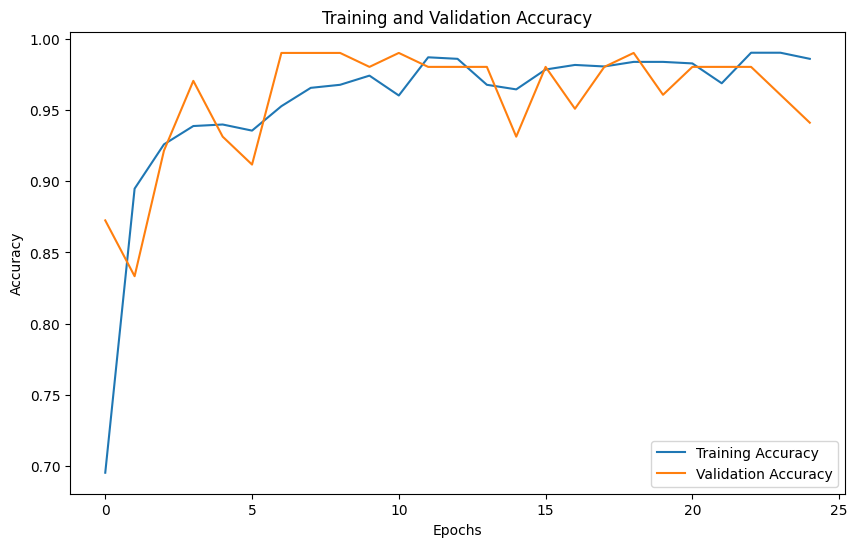

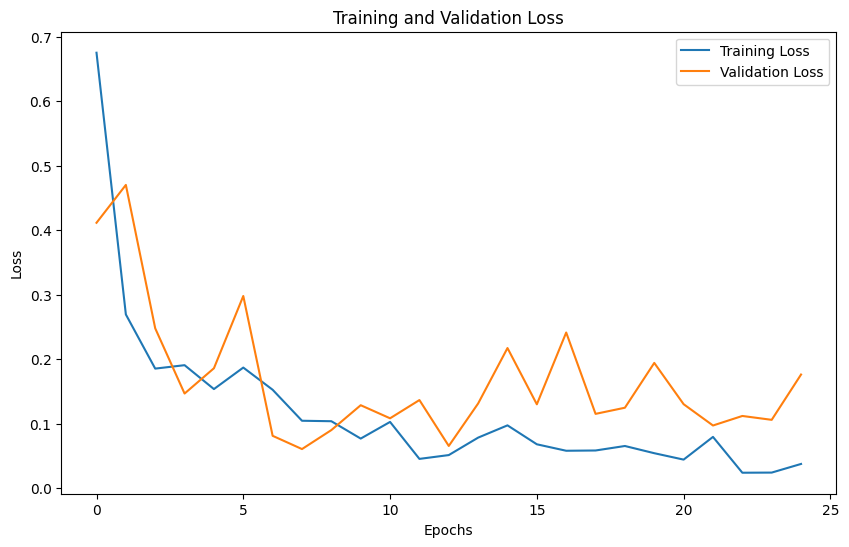

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 


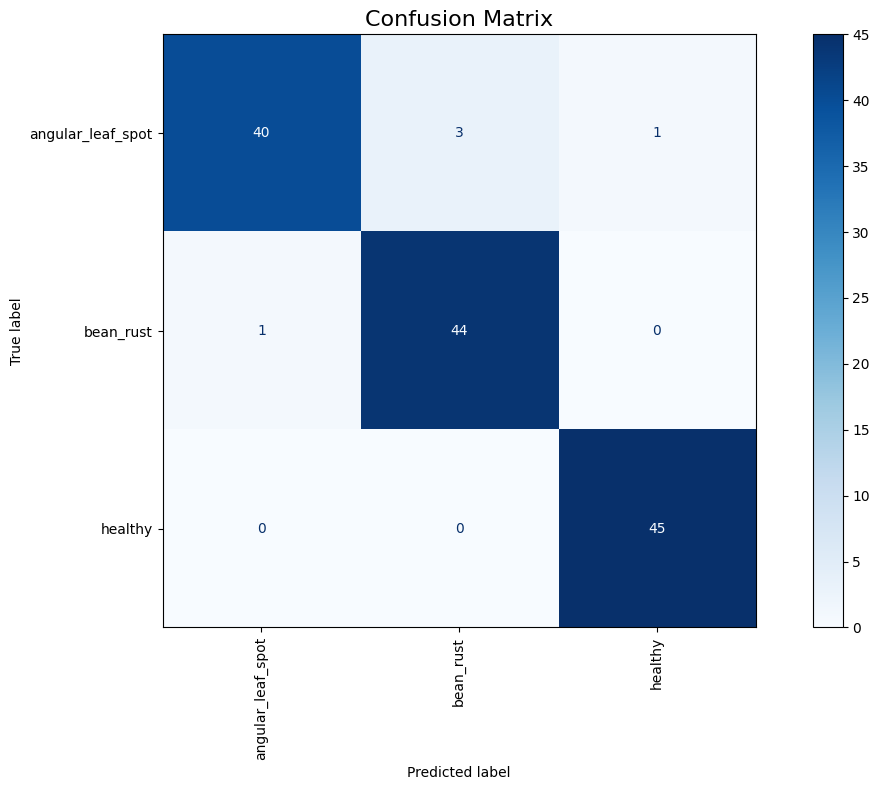

In [27]:
model_name = "EfficientNetV2B0"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B1

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5230 - loss: 0.9909 - val_accuracy: 0.8824 - val_loss: 0.3161
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.8167 - loss: 0.4242 - val_accuracy: 0.8824 - val_loss: 0.3563
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9062 - loss: 0.2924 - val_accuracy: 0.9804 - val_loss: 0.1337
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.9265 - loss: 0.2142 - val_accuracy: 0.9804 - val_loss: 0.1099
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.9513 - loss: 0.1386 - val_accuracy: 0.9706 - val_loss: 0.1148
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9588 - loss: 0.1363 - val_accuracy: 0.9020 - val_loss: 0.3091
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.9528 - loss: 0.1240 - val_accuracy: 0.9804 - val_loss: 0.0892
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.9456 - loss: 0.1665 - val_accuracy: 0.9

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.98      1.00      0.99        44
        bean_rust       1.00      0.98      0.99        45
          healthy       1.00      1.00      1.00        45

         accuracy                           0.99       134
        macro avg       0.99      0.99      0.99       134
     weighted avg       0.99      0.99      0.99       134



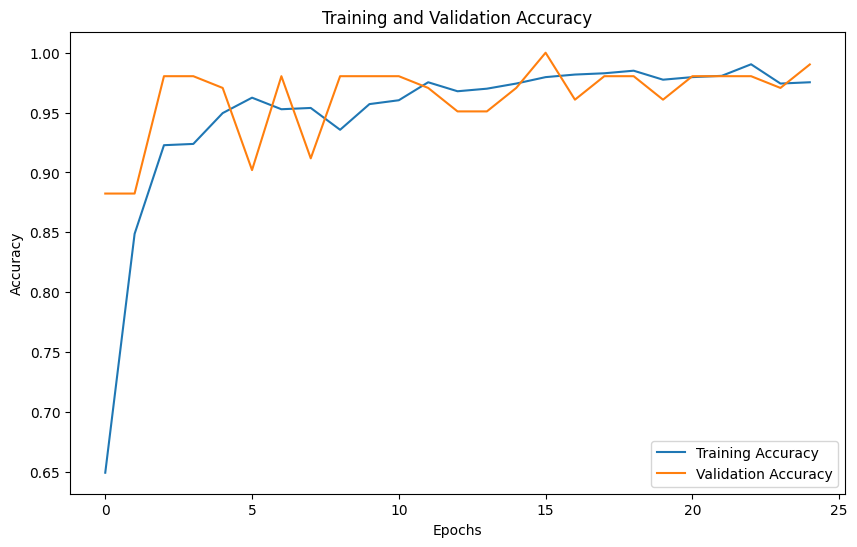

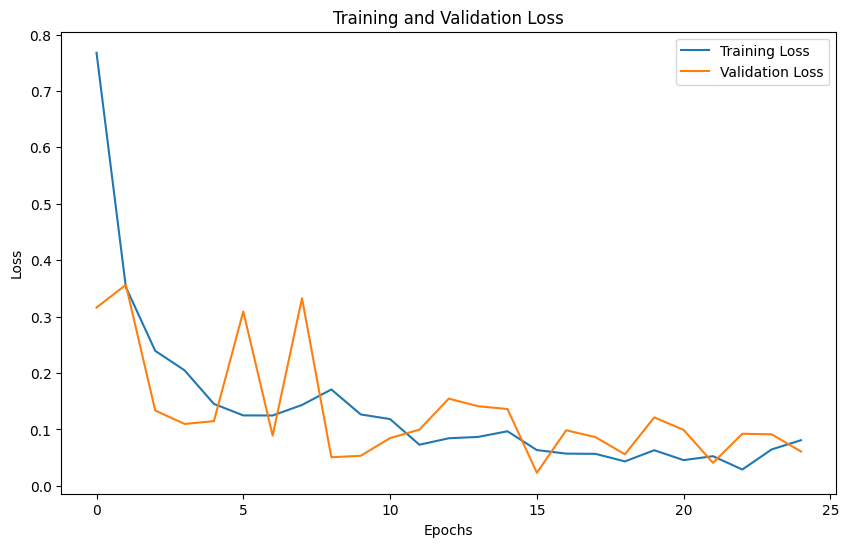

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 


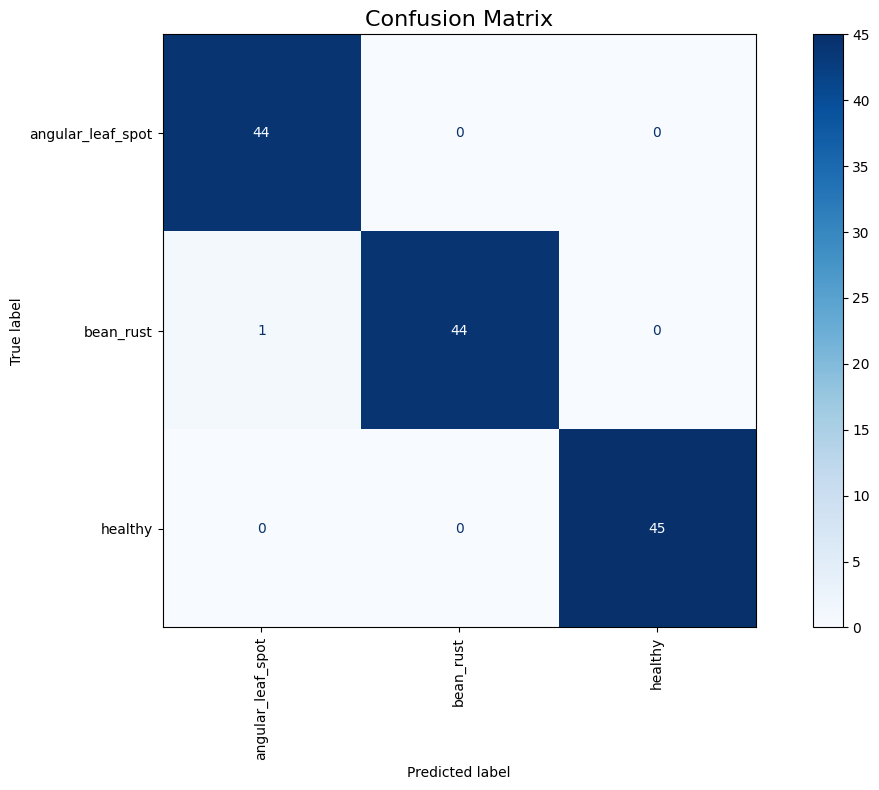

In [28]:
model_name = "EfficientNetV2B1"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B2

/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1734478272.047827   13794 service.cc:148] XLA service 0x7f640c002db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734478272.049002   13794 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-18 06:31:12.899578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734478275.911624   13794 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734478309.363190   13794 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5939 - loss: 0.8528 - val_accuracy: 0.7941 - val_loss: 0.4336
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.8517 - loss: 0.3888 - val_accuracy: 0.9412 - val_loss: 0.1678
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.9123 - loss: 0.2508 - val_accuracy: 0.9510 - val_loss: 0.2207
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9062 - loss: 0.2644 - val_accuracy: 0.9902 - val_loss: 0.0562
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9441 - loss: 0.1628 - val_accuracy: 0.9608 - val_loss: 0.0998
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9511 - loss: 0.1299 - val_accuracy: 0.9804 - val_loss: 0.1011
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.9686 - loss: 0.0897 - val_accuracy: 0.9510 - val_loss: 0.1407
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.9763 - loss: 0.0768 - val_accuracy: 0.9804 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       1.00      0.95      0.98        44
        bean_rust       0.96      0.98      0.97        45
          healthy       0.98      1.00      0.99        45

         accuracy                           0.98       134
        macro avg       0.98      0.98      0.98       134
     weighted avg       0.98      0.98      0.98       134



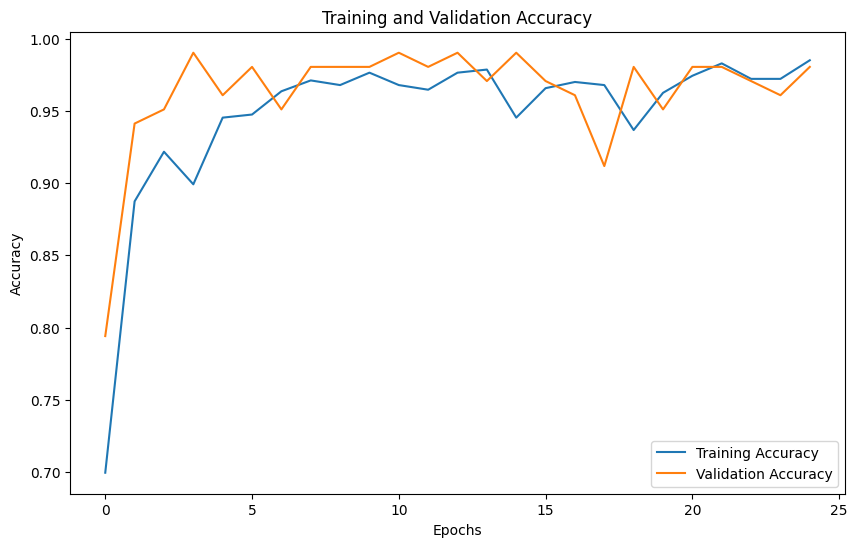

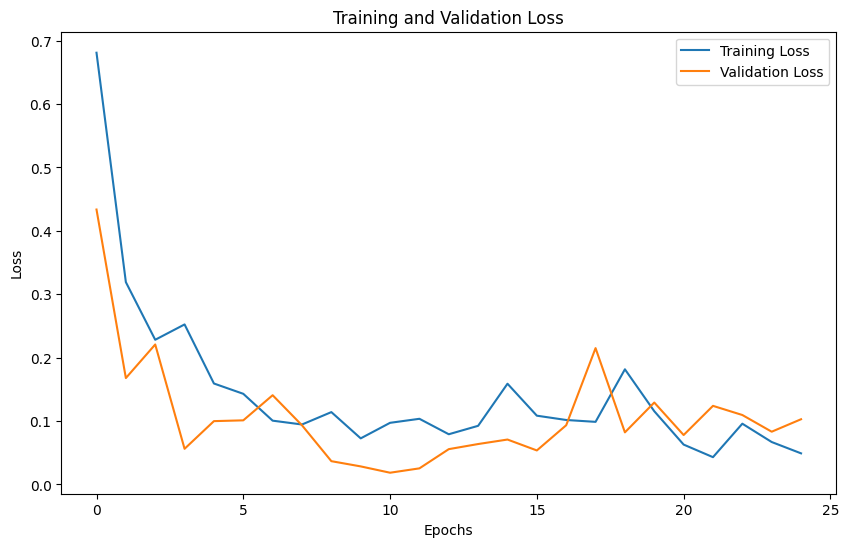

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 


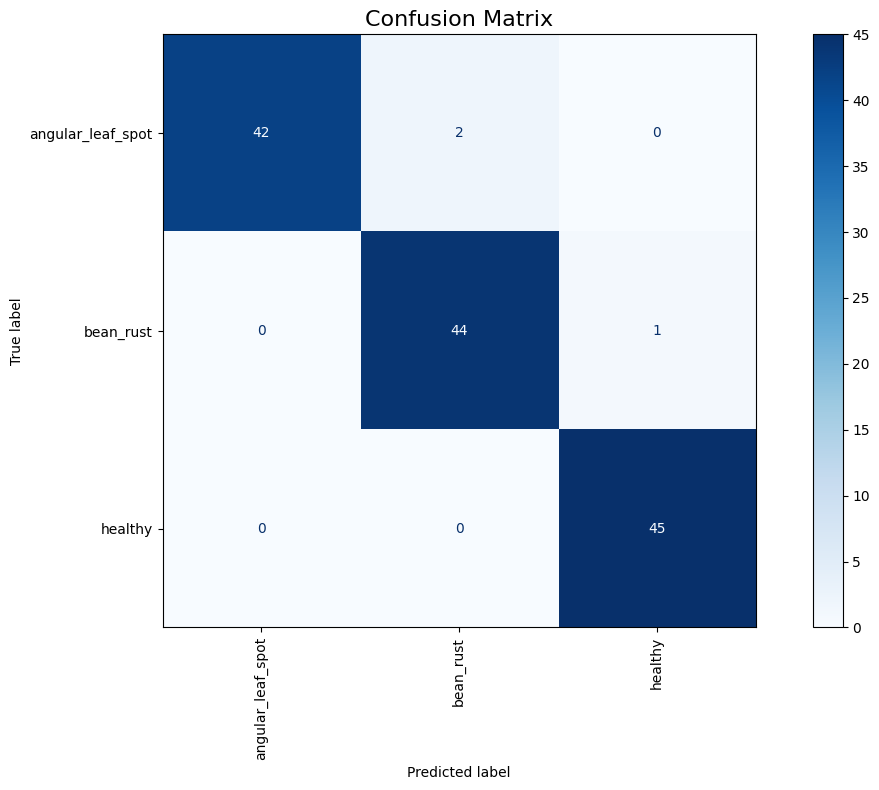

In [20]:
batch_size = 4

model_name = "EfficientNetV2B2"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B3

/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1734478705.306309   16304 service.cc:148] XLA service 0x7f8f98003410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734478705.306419   16304 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-18 06:38:26.241959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734478710.954754   16304 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734478748.810998   16304 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5521 - loss: 0.9138 - val_accuracy: 0.8431 - val_loss: 0.3507
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.8695 - loss: 0.3331 - val_accuracy: 0.9510 - val_loss: 0.1642
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.9121 - loss: 0.2473 - val_accuracy: 0.9902 - val_loss: 0.1210
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.9291 - loss: 0.1846 - val_accuracy: 0.9804 - val_loss: 0.0779
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.9224 - loss: 0.1774 - val_accuracy: 0.9902 - val_loss: 0.0616
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9602 - loss: 0.1330 - val_accuracy: 0.9706 - val_loss: 0.0773
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9428 - loss: 0.1656 - val_accuracy: 0.9902 - val_loss: 0.1112
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.9549 - loss: 0.1166 - val_accuracy: 0.9706 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.96      0.98      0.97        44
        bean_rust       0.98      1.00      0.99        45
          healthy       1.00      0.96      0.98        45

         accuracy                           0.98       134
        macro avg       0.98      0.98      0.98       134
     weighted avg       0.98      0.98      0.98       134



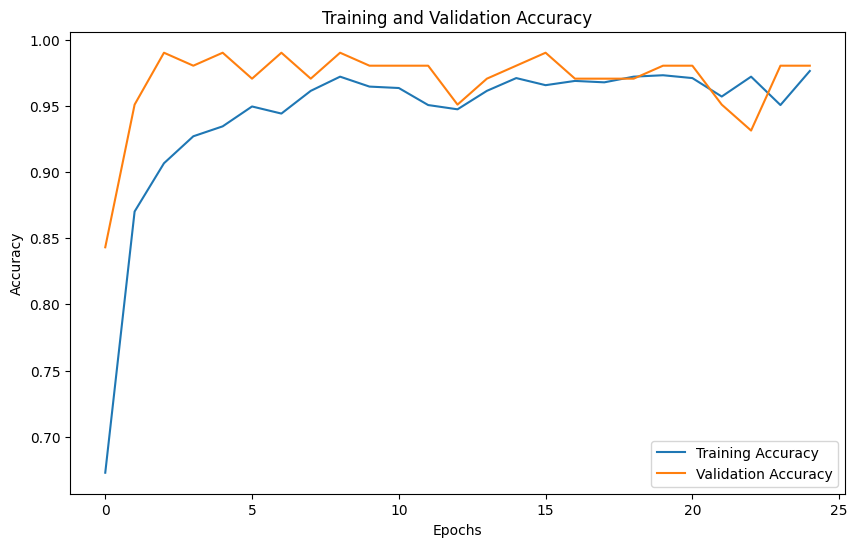

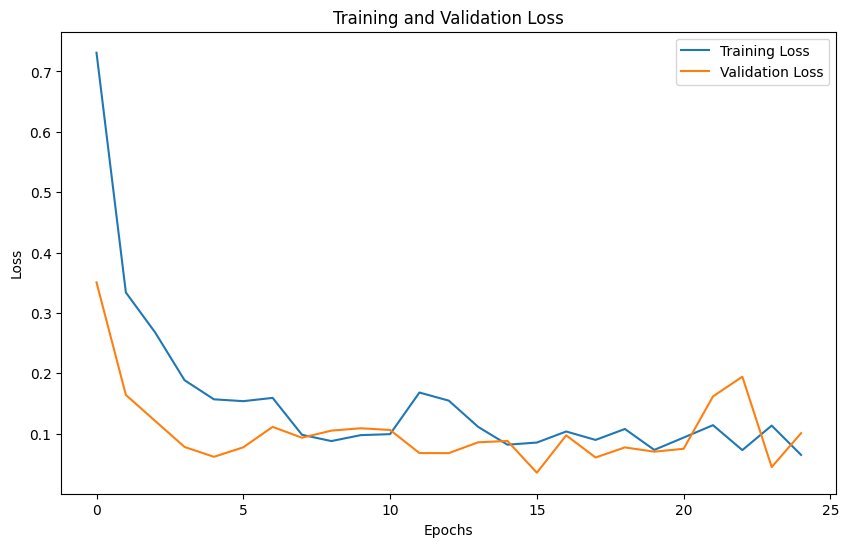

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 


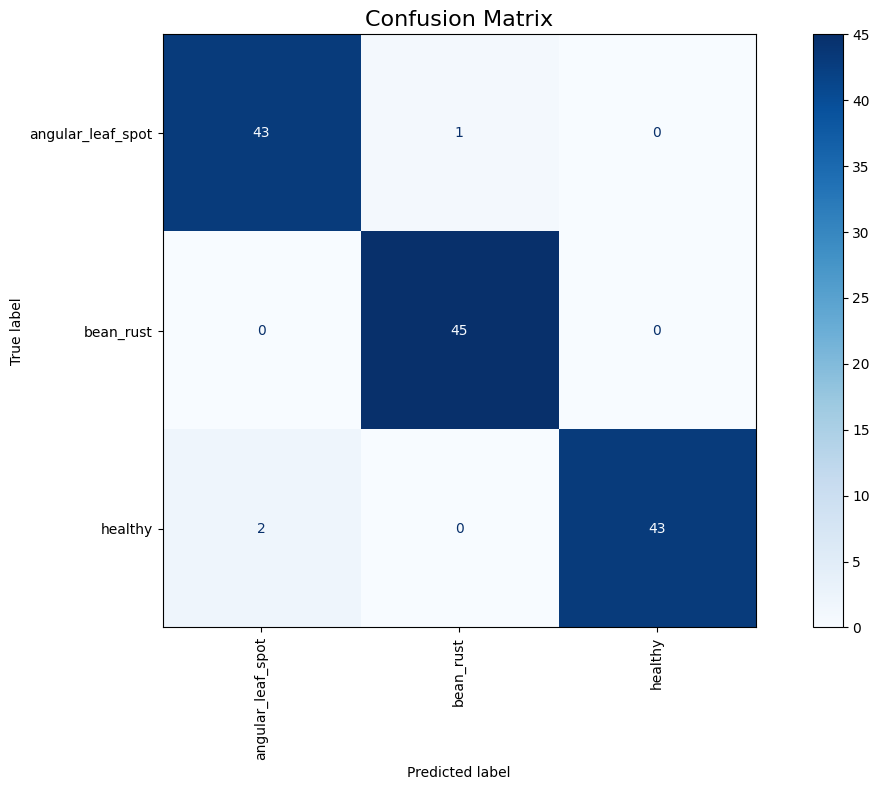

In [18]:
batch_size = 4

model_name = "EfficientNetV2B3"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B0Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4131 - loss: 1.1330 - val_accuracy: 0.6667 - val_loss: 0.8142
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.6237 - loss: 0.9218 - val_accuracy: 0.6667 - val_loss: 0.7747
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.6495 - loss: 0.8125 - val_accuracy: 0.7353 - val_loss: 0.6802
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.6534 - loss: 0.7995 - val_accuracy: 0.7843 - val_loss: 0.6134
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.6991 - loss: 0.7201 - val_accuracy: 0.7255 - val_loss: 0.6934
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.6745 - loss: 0.7620 - val_accuracy: 0.7255 - val_loss: 0.7318
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - accuracy: 0.6669 - loss: 0.7729 - val_accuracy: 0.6765 - val_loss: 0.7012
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.5619 - loss: 0.9716 - val_accuracy: 0.68

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.94      0.36      0.52        44
        bean_rust       0.55      0.93      0.69        45
          healthy       0.83      0.76      0.79        45

         accuracy                           0.69       134
        macro avg       0.77      0.68      0.67       134
     weighted avg       0.77      0.69      0.67       134



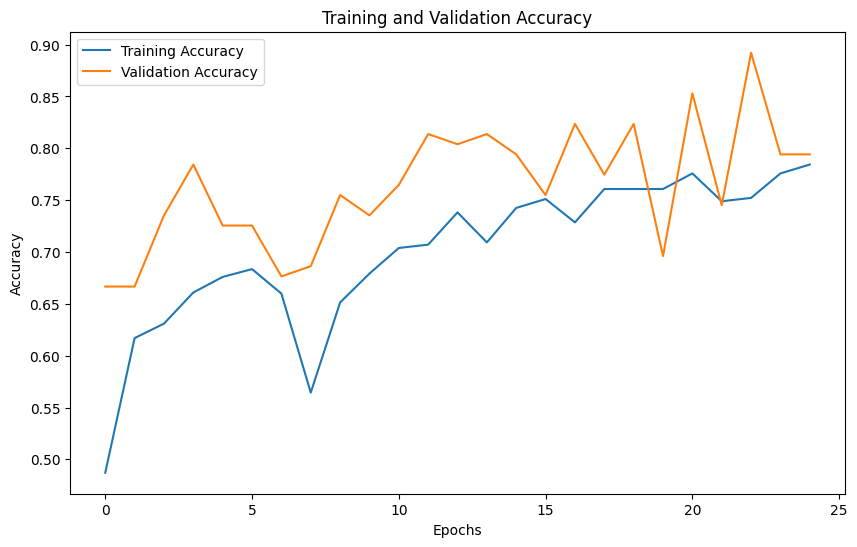

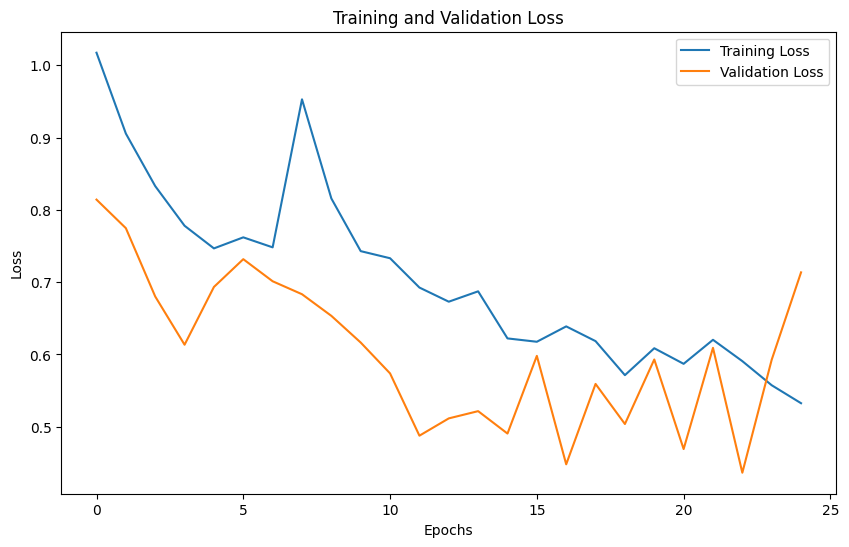

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step 


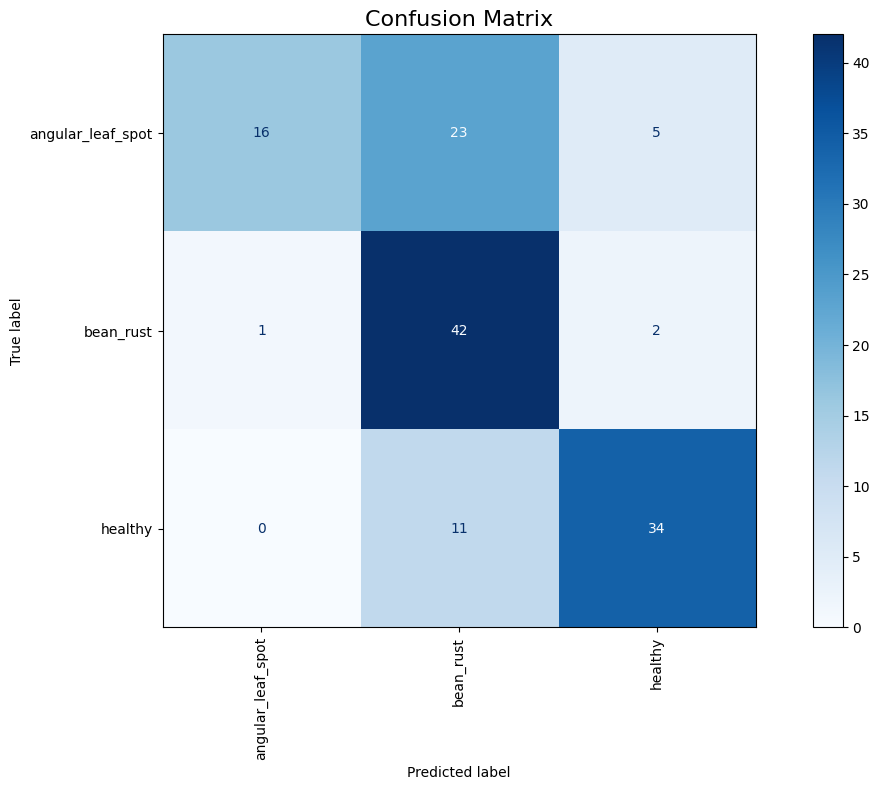

In [25]:
model_name = "EfficientNetV2B0Modifikasi"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B1Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


2024-12-23 21:55:53.367221: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[576,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,15,15]{3,2,1,0}, f32[32,576,15,15]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-23 21:55:53.939279: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.572061025s
Trying algorithm eng18{k11=0} for conv (f32[576,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,15,15]{3,2,1,0}, f32[32,576,15,15]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convBackward

30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.4158 - loss: 1.1248 - val_accuracy: 0.5686 - val_loss: 0.9326
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.5644 - loss: 0.9846 - val_accuracy: 0.7059 - val_loss: 0.9318
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.6137 - loss: 0.8888 - val_accuracy: 0.6275 - val_loss: 0.7730
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.6101 - loss: 0.9385 - val_accuracy: 0.6275 - val_loss: 1.0094
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.6263 - loss: 0.8409 - val_accuracy: 0.7255 - val_loss: 0.7381
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.6600 - loss: 0.7445 - val_accuracy: 0.6667 - val_loss: 0.7822
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.6691 - loss: 0.7458 - val_accuracy: 0.7255 - val_loss: 0.7648
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.6941 - loss: 0.7438 - val_accuracy: 0.7353 

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.97      0.70      0.82        44
        bean_rust       0.76      0.82      0.79        45
          healthy       0.85      1.00      0.92        45

         accuracy                           0.84       134
        macro avg       0.86      0.84      0.84       134
     weighted avg       0.86      0.84      0.84       134



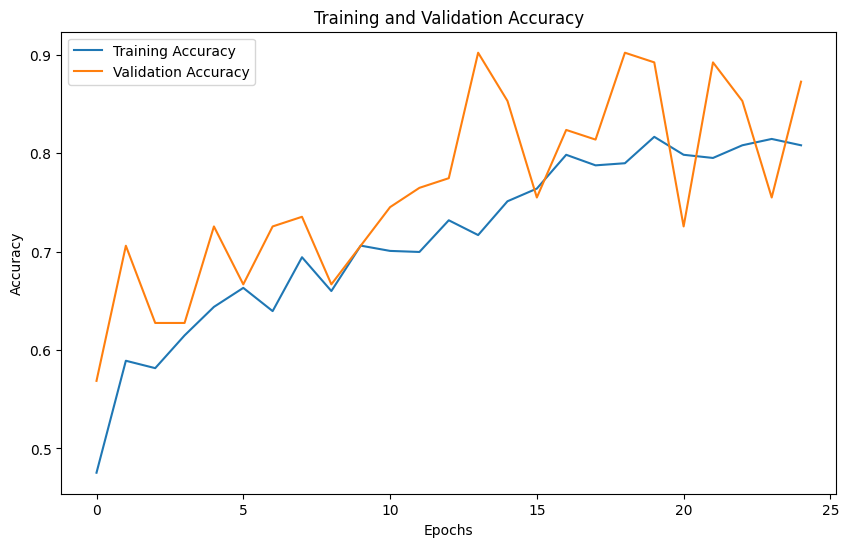

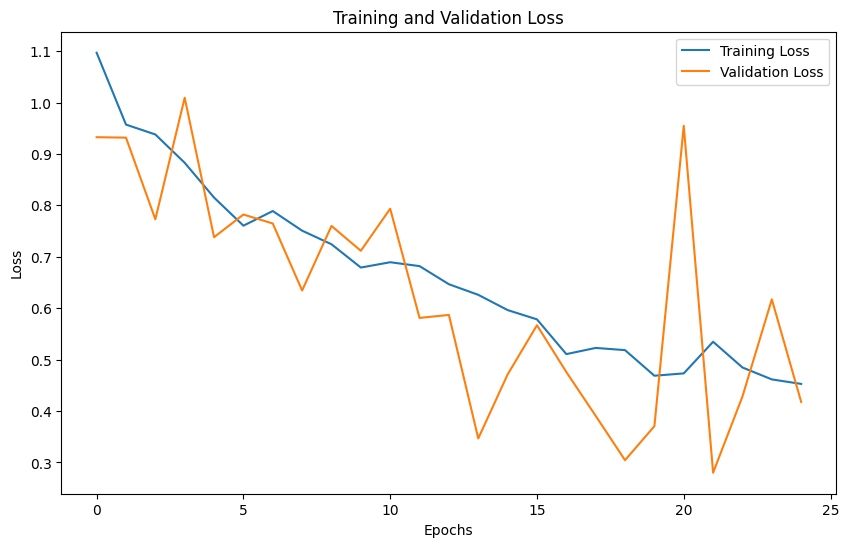

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


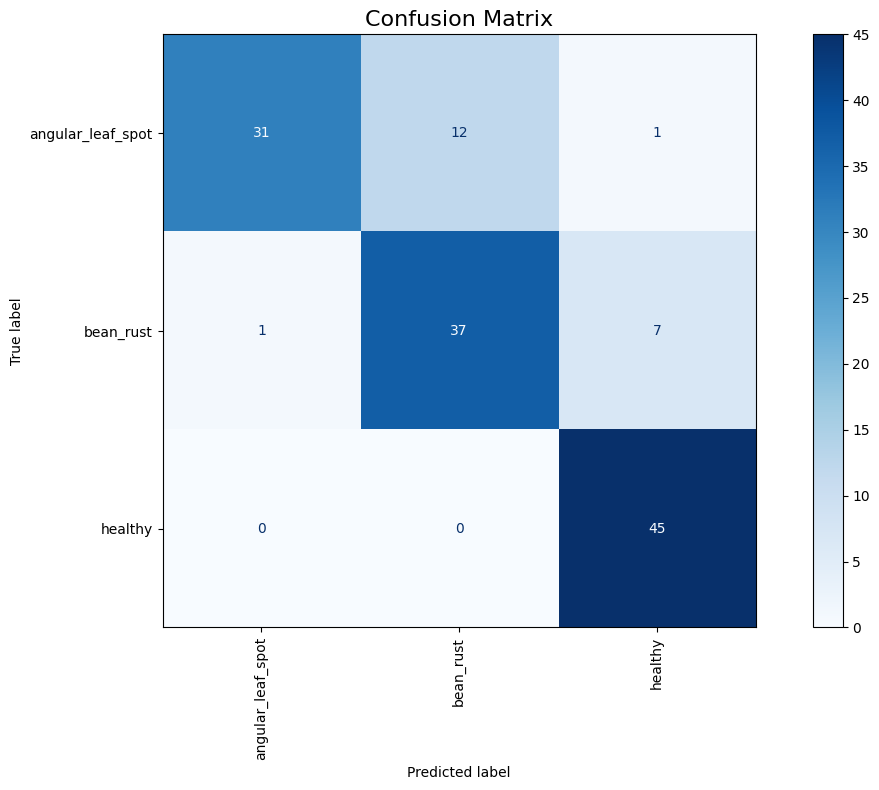

In [26]:
model_name = "EfficientNetV2B1Modifikasi"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B2Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Epoch 1/25


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - accuracy: 0.3783 - loss: 1.2470 - val_accuracy: 0.5294 - val_loss: 0.9848
Epoch 2/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.4856 - loss: 1.0308 - val_accuracy: 0.5392 - val_loss: 0.9060
Epoch 3/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.4965 - loss: 1.0305 - val_accuracy: 0.5294 - val_loss: 0.9478
Epoch 4/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5121 - loss: 1.0096 - val_accuracy: 0.5490 - val_loss: 0.9432
Epoch 5/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.4206 - loss: 1.0377 - val_accuracy: 0.4020 - val_loss: 1.0420
Epoch 6/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4162 - loss: 1.0659 - val_accuracy: 0.6275 - val_loss: 0.8498
Epoch 7/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.4955 - loss: 1.0169 - val_accuracy: 0.6667 - val_loss: 0.9205
Epoch 8/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.5424 - loss: 0.9659 - val_accurac

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.95      0.93      0.94        44
        bean_rust       0.85      0.87      0.86        45
          healthy       0.91      0.91      0.91        45

         accuracy                           0.90       134
        macro avg       0.90      0.90      0.90       134
     weighted avg       0.90      0.90      0.90       134



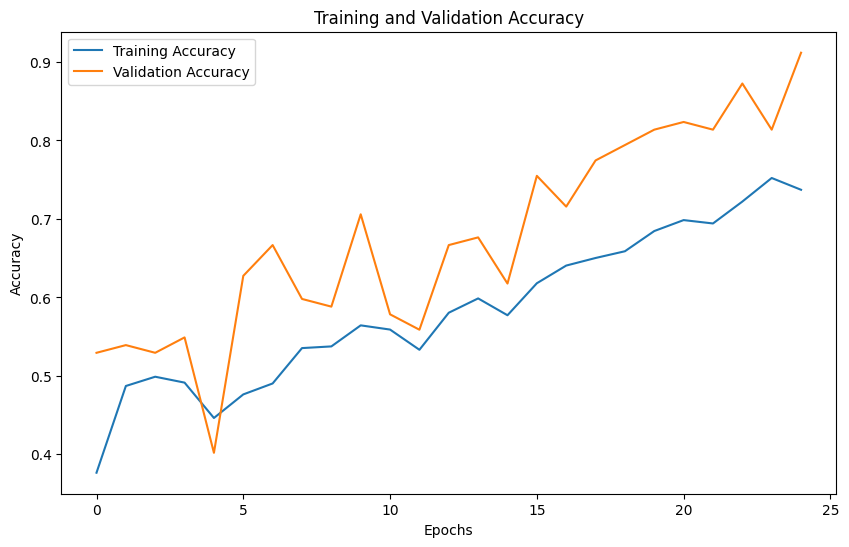

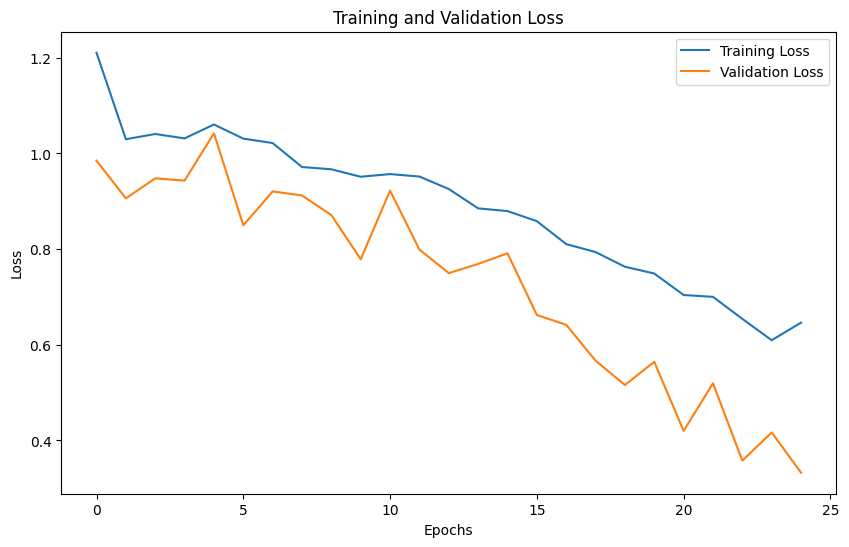

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 


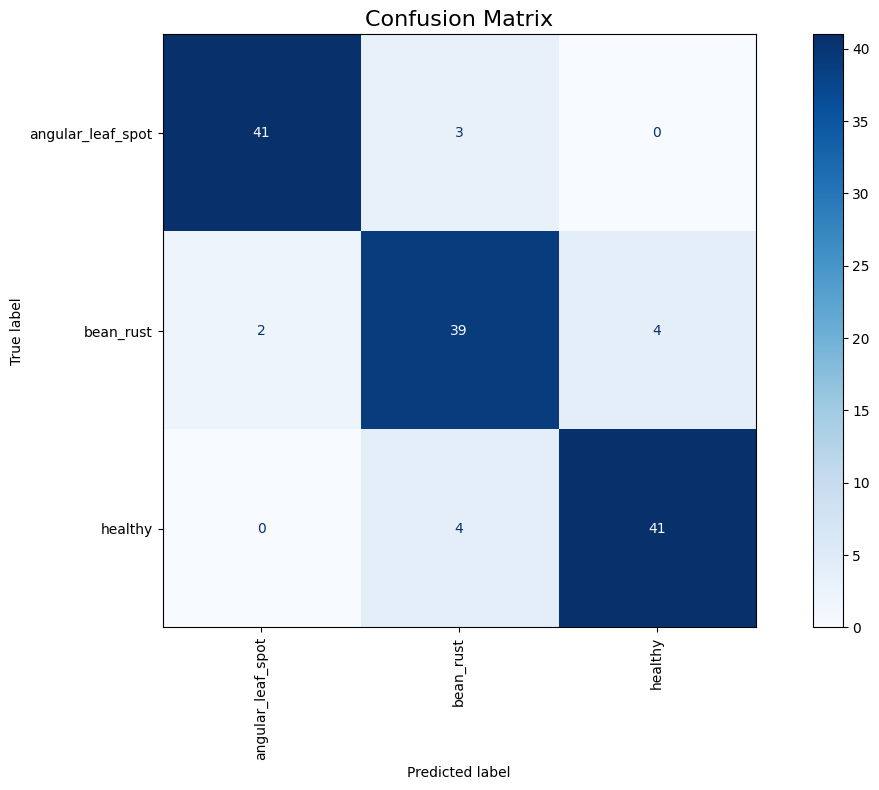

In [27]:
batch_size = 4

model_name = "EfficientNetV2B2Modifikasi"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EfficientNetV2B3Modifikasi

In [ ]:
batch_size = 4

model_name = "EfficientNetV2B3Modifikasi"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Epoch 1/25


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 102s 120ms/step - accuracy: 0.3588 - loss: 1.2861 - val_accuracy: 0.4804 - val_loss: 1.5059
Epoch 2/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.4305 - loss: 1.0772 - val_accuracy: 0.3922 - val_loss: 1.0627
Epoch 3/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.4636 - loss: 1.0611 - val_accuracy: 0.4706 - val_loss: 1.0223
Epoch 4/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.4803 - loss: 1.0129 - val_accuracy: 0.5588 - val_loss: 0.8928
Epoch 5/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.4988 - loss: 1.0045 - val_accuracy: 0.5098 - val_loss: 0.9272
Epoch 6/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.4843 - loss: 1.0094 - val_accuracy: 0.5294 - val_loss: 1.0094
Epoch 7/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.5187 - loss: 0.9859 - val_accuracy: 0.5882 - val_loss: 0.8365
Epoch 8/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.5181 - loss: 0.9508 - val_accur

2024-12-23 22:19:16.760648: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_480582__.1975] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-12-23 22:20:19.752085: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m3.019551808s

********************************
[Compiling module a_inference_one_step_on_data_480582__.1975] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step    

# Evaluation

## kFold

In [ ]:
# def kfold_train(dataset_path, img_size, batch_size, epochs_size, model_name, best_model_dir, k=5):
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)
#     train_path = os.path.join(base_path, 'training')
#     class_names = os.listdir(train_path)
#     data_paths = []
#     labels = []

#     # Collect all image paths and labels
#     for class_index, class_name in enumerate(class_names):
#         class_folder = os.path.join(train_path, class_name)
#         for img_file in os.listdir(class_folder):
#             data_paths.append(os.path.join(class_folder, img_file))
#             labels.append(class_index)
    
#     data_paths = np.array(data_paths)
#     labels = np.array(labels)

#     for fold, (train_idx, val_idx) in enumerate(kf.split(data_paths), start=1):
#         print(f"Starting fold {fold}/{k}")

#         # Split data into train and validation sets based on KFold indices
#         train_data_paths = data_paths[train_idx]
#         train_labels = labels[train_idx].astype(str)
#         val_data_paths = data_paths[val_idx]
#         val_labels = labels[val_idx].astype(str)

#         # Build model for the current fold
#         num_classes = len(np.unique(train_labels))  # Get unique class count
#         model = load_base_model("MobileNetV3Small", img_size, img_size, trainable_percentage=0.3)
#         model = build_model(model, num_classes)
#         compile_model(model, learning_rate)

#         # Train model and save results for each fold
#         history, training_duration = train_model(model, train_generator, val_generator, epochs)
        
#         test_loss, test_accuracy = evaluate_model(model, test_generator)

#         print(f"Test acc: {test_accuracy}")

#         print(f"Completed fold {fold}/{k}")

In [ ]:
# model_name = "MobileNetV3Small"
# best_model_dir = "results/best_model/classifier_2024-12-16 23:03:20.h5"

# # Run k-fold cross-validation
# kfold_train(
#     dataset_path,
#     img_height,
#     batch_size,
#     epochs_size,
#     model_name,
#     best_model_dir,
#     k=5 
# )